In [1]:
%matplotlib inline

# plotting
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt

# math and data manipulation
import numpy as np
import pandas as pd

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed

# Tensorflow
from tensorflow import keras 
import tensorflow as tf

# progress bar
from tqdm import tqdm

from csef.utils import performance

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

## Data Loading

In [2]:
data_path = Path('..', '..', 'data', 'raw')
consumption_train = pd.read_csv(data_path / 'consumption_train.csv', 
                                index_col=0, parse_dates=['timestamp'])
cold_start_test = pd.read_csv(data_path / 'cold_start_test.csv', 
                              index_col=0, parse_dates=['timestamp'])
submission_format = pd.read_csv(data_path / 'submission_format.csv',
                                index_col='pred_id',
                                parse_dates=['timestamp'])

## Features

In [6]:
from sklearn.preprocessing import MinMaxScaler

def create_lagged_features(df, cols, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=cols)
    
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        for col in cols:
            df = df.join(df[col].shift(i).pipe(_rename_lag, i))

    df.dropna(inplace=True)
    return df

def prepare_training_data(df, cols, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    
    scalers = {}
    
    df = df.fillna(0)
    
    # scale training data
    df_vals = df.copy()
    for col in cols:
        scalers[col] = MinMaxScaler(feature_range=(-1, 1))
        df_vals[col] = scalers[col].fit_transform(df[col].values.reshape(-1, 1))

    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(df_vals, cols, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop(cols, axis=1).values
    y = consumption_lagged[cols].values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scalers

In [7]:
sample_ser = (consumption_train
                           .series_id
                           .sample().values[0])
sample_df = consumption_train[consumption_train.series_id == sample_ser]

In [8]:
cols = ['consumption', 'temperature']
X, y, scalers = prepare_training_data(sample_df[cols], cols, lag=24)

In [9]:
X.shape

(648, 1, 48)

In [10]:
y.shape

(648, 2)

In [11]:
consumption_train.temperature.isnull().sum()

228689

## Model fitting

In [14]:
# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix
cols = ['consumption', 'temperature']
n_cols = len(cols)
n_features = n_cols
lag = 24

# model parameters
num_neurons = lag * n_cols
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag * n_cols)

# instantiate a sequential model
model = keras.Sequential()

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(keras.layers.LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(keras.layers.Dense(n_features))

# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

In [ ]:
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 3

total_timer = performance.Timer()

epoch_timers = []

num_sers = consumption_train['series_id'].nunique()

callbacks = [
  # Write TensorBoard logs to `./logs` directory
  keras.callbacks.TensorBoard(log_dir='./logs')
]

for i in range(num_passes_through_data):
    
    epoch_timer = performance.Timer()
    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in tqdm(consumption_train.groupby('series_id'),
                                 total=num_sers,
                                 desc='Learning Consumption Trends - Epoch'):

        # prepare the data
        X, y, scalers = prepare_training_data(ser_data[cols], cols, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, callbacks=callbacks)
        model.reset_states()
    
    epoch_timers.append(epoch_timer)
    
    print(f'Finish an epoch in {epoch_timer.get_time()}')

total_end_timer = performance.Timer()

In [16]:
epoch_timers

In [17]:
model.save('../../data/model/multivariate-lstm-20181023-02.hdf5')

## Predict 

In [128]:
model2 = keras.models.load_model('../../data/model/multivariate-lstm-20181023-02.hdf5')
my_submission = submission_format.copy()

In [131]:
def generate_hourly_forecast(num_pred_hours, consumption, model, scalers, lag, cols):
    """ Uses last hour's prediction to generate next for num_pred_hours, 
        initialized by most recent cold start prediction. Inverts scale of 
        predictions before return.
    """
    # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
    X = consumption[cols].copy()
    X = X.tail(lag)
    for col in cols:
        X[col] = scalers[col].transform(X[col].values.reshape(-1, 1))
        
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        X = np.flip(X.values.ravel(), axis=0)
        yhat = model.predict(X.values.reshape(1, 1, lag*n_cols), batch_size=1)[0]
        preds_scaled[i] = yhat[0]
        
        # update X to be latest data plus prediction
        col_0 = pd.Series(X[cols[0]].values.ravel(), name=cols[0]).shift(-1).fillna(yhat[0])
        col_1 = pd.Series(X[cols[1]].values.ravel(), name=cols[1]).shift(-1).fillna(yhat[1])
        X = pd.concat([col_0, col_1], axis=1)
        
    # revert scale back to original range
    hourly_preds = scalers[cols[0]].inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
    return hourly_preds

In [ ]:
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = my_submission.series_id.nunique()

model2.reset_states()

for ser_id, pred_df in tqdm(my_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = pred_window_to_num_preds[pred_window]
    num_pred_hours = pred_window_to_num_pred_hours[pred_window]
    
    # prepare cold start data
    series_data = cold_start_test[cold_start_test.series_id == ser_id][cols]
    series_data = series_data.fillna(0)
    
    cold_X, cold_y, scalers = prepare_training_data(series_data, cols, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model2.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(num_pred_hours, series_data, model2, scalers, lag, cols)
    
    # reduce by taking sum over each sub window in pred window
    reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = my_submission.series_id == ser_id
    my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds

In [133]:
my_submission[my_submission.prediction_window == 'hourly'].consumption.describe()

count    5.808000e+03
mean     1.663550e+05
std      6.164732e+05
min     -2.520992e+04
25%      1.574151e+04
50%      3.635468e+04
75%      9.202935e+04
max      5.237062e+06
Name: consumption, dtype: float64

In [134]:
my_submission[my_submission.prediction_window == 'daily'].consumption.describe()

count    1.337000e+03
mean     3.362031e+06
std      9.920729e+06
min      4.122322e+03
25%      3.752426e+05
50%      8.644375e+05
75%      2.609598e+06
max      1.166078e+08
Name: consumption, dtype: float64

In [135]:
my_submission[my_submission.prediction_window == 'weekly'].consumption.describe()

count    3.840000e+02
mean     2.292892e+07
std      6.341716e+07
min      2.659822e+04
25%      3.029620e+06
50%      7.408586e+06
75%      1.979482e+07
max      7.287377e+08
Name: consumption, dtype: float64

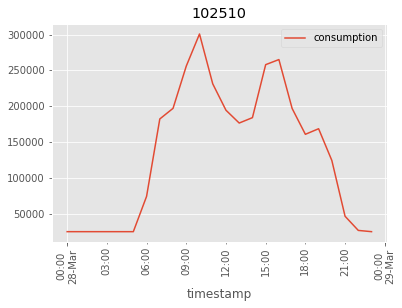

In [136]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'hourly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

In [137]:
my_submission.head(5)

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
0,102781,2013-03-03,19.931250,375390.546542,daily
1,102781,2013-03-04,20.034375,374087.952698,daily
2,102781,2013-03-05,19.189583,380555.628372,daily
3,102781,2013-03-06,18.397917,387064.772238,daily
4,102781,2013-03-07,20.762500,395679.485560,daily


In [138]:
save_path = Path('..', '..', 'data', 'submissions')
save_path.mkdir(exist_ok=True, parents=True)

my_submission.to_csv(save_path / "multivariate-20181023-revel.csv", index_label='pred_id')

The result is 0.4930 (rank 75/1176)